In [13]:
%cd ..

/Users/juliuslipp/projects/current/mixedbread/mixedbread-ai/packages/ofen


/Users/juliuslipp/projects/current/mixedbread/mixedbread-ai/packages/ofen/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [19]:
%pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.9/245.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 554.1 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Import necessary libraries
import time
import asyncio
import pandas as pd
from ofen.batch_processor.batch_processor import BatchProcessorConfig
from ofen.model_engines.embedding_engine import EmbeddingEngine
from ofen.models.text_encoder.text_encoder_config import TextEncoderConfig
from ofen.models.text_encoder.text_encoder import TextEncoder

# Set up model configuration and initialize model and engine
batch_size = 64
model_config = TextEncoderConfig.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
engine = EmbeddingEngine(model_config=model_config, batch_processor_config=BatchProcessorConfig(max_batch_size=batch_size))
await engine.start()
model = TextEncoder(text_encoder_config=model_config)

# Define complex and longer test sentences
test_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "In a distant land, far beyond the reaches of any known map, there lies a hidden valley shrouded in mist and mystery.",
    "To be, or not to be, that is the question: Whether 'tis nobler in the mind to suffer the slings and arrows of outrageous fortune, or to take arms against a sea of troubles and by opposing end them.",
    "Once upon a time in a small village nestled between the mountains, there lived a young girl with a heart full of dreams and a spirit that could not be tamed.",
    "Artificial intelligence and machine learning are rapidly advancing fields that are transforming industries and reshaping the future of technology."
] * 200  # Repeat to create a large dataset for testing

/Users/juliuslipp/projects/current/mixedbread/mixedbread-ai/packages/ofen/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
BetterTransformer is not available on MPS. Continuing with the original model.


In [21]:
# Function to benchmark model.pipe
def benchmark_model_pipe(sentences, batch_size):
    start_time = time.time()
    for i in range(0, len(sentences), batch_size):
        model.pipe(sentences[i:i + batch_size])
    end_time = time.time()
    return end_time - start_time

# Function to benchmark engine.encode_text
async def benchmark_engine_encode_text(sentences, batch_size):
    start_time = time.time()
    promises = []
    for i in range(0, len(sentences), batch_size):
        promises.append(engine.encode_sentences(sentences[i:i + batch_size]))
    await asyncio.gather(*promises)
    end_time = time.time()
    return end_time - start_time

# Run benchmarks for different batch sizes
batch_sizes = [1, 4, 8, 16, 32, 64]
results = []

for batch_size in batch_sizes:
    model_time = benchmark_model_pipe(test_sentences, batch_size)
    engine_time = await benchmark_engine_encode_text(test_sentences, batch_size)
    results.append({
        'batch_size': batch_size,
        'model_time': model_time,
        'engine_time': engine_time
    })

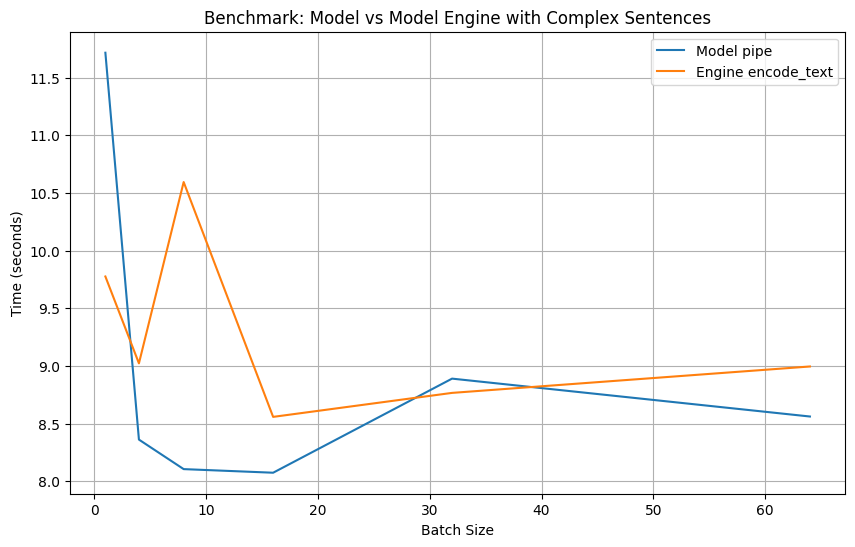

In [22]:
# Convert results to DataFrame for easy visualization
df_results = pd.DataFrame(results)


# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_results['batch_size'], df_results['model_time'], label='Model pipe')
plt.plot(df_results['batch_size'], df_results['engine_time'], label='Engine encode_text')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Benchmark: Model vs Model Engine with Complex Sentences')
plt.legend()
plt.grid(True)
plt.show()